In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from skopt import BayesSearchCV
from skopt.space import Real, Integer

pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

## Feature Engineering

Read the Training Dataset (USDT in AAVE V2 on ETH Mainet) with the target.


Also read the other AAVE pools and external adicional data as explanatory variables

In [81]:
# Traning Dataset
dataset = pd.read_csv('dataset-AAVE-ETH-V2-USDT.csv', parse_dates=["timestamp"], index_col="timestamp")

# AAVE Datastes
ethV2 = pd.read_csv('dataset-AAVE-ETH-V2-others.csv', parse_dates=["timestamp"], index_col="timestamp")
ethV3 = pd.read_csv('dataset-AAVE-ETH-V3.csv', parse_dates=["timestamp"], index_col="timestamp")
polygonV3 = pd.read_csv('dataset-AAVE-Polygon-V3-others.csv', parse_dates=["timestamp"], index_col="timestamp")
avalanche3 = pd.read_csv('dataset-AAVE-Avalanche-V3-others.csv', parse_dates=["timestamp"], index_col="timestamp")
optimismV3 = pd.read_csv('dataset-AAVE-Optimism-V3-others.csv', parse_dates=["timestamp"], index_col="timestamp")

# Other Datasets
binance = pd.read_csv('binance-5min.csv', parse_dates=["timestamp"], index_col="timestamp")
coingecko = pd.read_csv('coingecko-proc.csv', parse_dates=["timestamp"], index_col="timestamp")
tweets = pd.read_csv('tweets-proc.csv', parse_dates=["timestamp"], index_col="timestamp")


The rows where the target remained null (due to rolling and shift) are deleted.

In [82]:
dataset = dataset[dataset['target'].notna()]

Join the Datasets

In [83]:
# Join AAVE Datastes
dataset = dataset.join(ethV2).join(ethV3).join(polygonV3).join(avalanche3).join(optimismV3)

# Join Other Datasets
dataset = dataset.join(binance)

# Join Coingecko that has a Daily datapoint
dataset = pd.merge_asof(dataset, coingecko, left_index=True, right_index=True,
                        direction='backward', tolerance=pd.Timedelta('5 day'))

# Join Tweets
dataset = pd.merge_asof(dataset, tweets.tz_localize(None), left_index=True, right_index=True,
                       direction='backward', tolerance=pd.Timedelta('5 m'))


In [84]:
print(dataset.shape)
dataset.head()

(210158, 199)


,blockchain,symbol,liquidityRateAvg,liquidityRateMax,liquidityRateMin,stableBorrowRateAvg,stableBorrowRateMax,stableBorrowRateMin,variableBorrowRateAvg,variableBorrowRateMax,variableBorrowRateMin,SupplySum,WithdrawSum,BorrowSum,RepaySum,netSupplied,netBorrowed,netLiquid,target,AAVEliquidityRate-ethV2,AAVEnetSupplied-ethV2,AAVEnetLiquid-ethV2,CRVliquidityRate-ethV2,CRVnetSupplied-ethV2,CRVnetLiquid-ethV2,DAIliquidityRate-ethV2,DAInetSupplied-ethV2,DAInetLiquid-ethV2,LINKliquidityRate-ethV2,LINKnetSupplied-ethV2,LINKnetLiquid-ethV2,UNIliquidityRate-ethV2,UNInetSupplied-ethV2,UNInetLiquid-ethV2,USDCliquidityRate-ethV2,USDCnetSupplied-ethV2,USDCnetLiquid-ethV2,WBTCliquidityRate-ethV2,WBTCnetSupplied-ethV2,WBTCnetLiquid-ethV2,WETHliquidityRate-ethV2,WETHnetSupplied-ethV2,WETHnetLiquid-ethV2,AAVEliquidityRateethV3,AAVEnetSuppliedethV3,AAVEnetLiquidethV3,CRVliquidityRateethV3,CRVnetSuppliedethV3,CRVnetLiquidethV3,DAIliquidityRateethV3,...,USDCUSDTvolumeUsd,USDCUSDTtrades,USDTDAIPrice,USDTDAIvolumeUsd,USDTDAItrades,AAVEsentimentUp,AAVEcoingeckoScore,AAVEcommunityScore,AAVEcirculating,AAVEredditComments,BTCsentimentUp,BTCcoingeckoScore,BTCcommunityScore,BTCcirculating,BTCredditComments,CRVsentimentUp,CRVcoingeckoScore,CRVcommunityScore,CRVcirculating,CRVredditComments,DAIsentimentUp,DAIcoingeckoScore,DAIcommunityScore,DAIcirculating,DAIredditComments,ETHsentimentUp,ETHcoingeckoScore,ETHcommunityScore,ETHcirculating,ETHredditComments,LINKsentimentUp,LINKcoingeckoScore,LINKcommunityScore,LINKcirculating,LINKredditComments,USDCsentimentUp,USDCcoingeckoScore,USDCcommunityScore,USDCcirculating,USDCredditComments,USDTsentimentUp,USDTcoingeckoScore,USDTcommunityScore,USDTcirculating,USDTredditComments,ticket,count,repliesCount,retweetsCount,likesCount
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-01 00:55:00,ethereum,USDT,0.02,0.09,0.00,0.07,0.20,0.00,0.04,0.15,0.00,0.00,0.00,0.00,0.00,143655641.54,36310610.50,107345031.03,0.08,0.02,2209062.13,2209062.18,0.04,8376549.38,5062030.47,0.10,85021761.15,-12347576.75,0.00,22332378.87,22146997.70,0.00,2460950.70,2457047.23,0.05,306517233.72,49256506.43,0.00,7009.67,6716.30,0.00,337369.72,306680.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1010634.83,305.00,1.00,1711.30,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01 01:00:00,ethereum,USDT,0.09,0.09,0.09,0.18,0.18,0.18,0.13,0.13,0.13,394410.10,0.00,0.00,0.00,144050051.64,36310610.50,107739441.14,0.08,0.02,2209062.13,2209062.18,0.04,8376549.38,5062030.47,0.10,85419821.25,-11949516.64,0.00,22332378.87,22146997.70,0.00,2460950.70,2457047.23,0.05,306517233.72,49256506.43,0.00,7009.67,6716.30,0.00,337454.78,306745.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,827781.58,163.00,1.00,99442.21,36.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01 01:05:00,ethereum,USDT,0.04,0.09,0.00,0.10,0.19,0.00,0.05,0.14,0.00,0.00,486313.10,32306.61,0.00,143563738.54,36318550.17,107245188.37,0.09,0.02,2209635.58,2209635.63,0.02,8411990.30,5097471.39,0.10,85419821.25,-11949319.14,0.03,22333129.46,22147748.29,0.00,2460950.70,2457047.23,0.05,307104013.72,49345286.43,0.02,7007.58,6714.21,0.03,337616.26,306907.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,723856.91,154.00,1.00,17149.73,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01 01:10:00,ethereum,USDT,0.04,0.09,0.00,0.10,0.19,0.00,0.05,0.14,0.00,0.00,0.00,0.00,0.00,143563738.54,36318550.17,107245188.37,0.09,0.02,2209635.58,2209635.63,0.02,8411990.30,5097471.39,0.10,85419821.25,-11949324.23,0.03,22333129.46,22147748.29,0.00,2460950.70,2457047.23,0.05,30

Impute all null values by zero, since they represent the cases where no data existed at that moment in time.

In [91]:
dataset.fillna(0, inplace = True)

Correct the formats of the variables that remained as string

In [102]:
dataset.dtypes[dataset.dtypes == object]

blockchain         object
symbol             object
AAVEsentimentUp    object
BTCsentimentUp     object
CRVsentimentUp     object
DAIsentimentUp     object
ETHsentimentUp     object
USDCsentimentUp    object
USDTsentimentUp    object
ticket             object
dtype: object

In [107]:
dataset['AAVEsentimentUp'] = pd.to_numeric(dataset.AAVEsentimentUp)
dataset['BTCsentimentUp'] = pd.to_numeric(dataset.BTCsentimentUp)
dataset['CRVsentimentUp'] = pd.to_numeric(dataset.CRVsentimentUp)
dataset['DAIsentimentUp'] = pd.to_numeric(dataset.DAIsentimentUp)
dataset['ETHsentimentUp'] = pd.to_numeric(dataset.ETHsentimentUp)
dataset['USDCsentimentUp'] = pd.to_numeric(dataset.USDCsentimentUp)
dataset['USDTsentimentUp'] = pd.to_numeric(dataset.USDTsentimentUp)

dataset = dataset.drop(columns=['blockchain', 'symbol', 'ticket'])


Correlation between variables:

<AxesSubplot:>

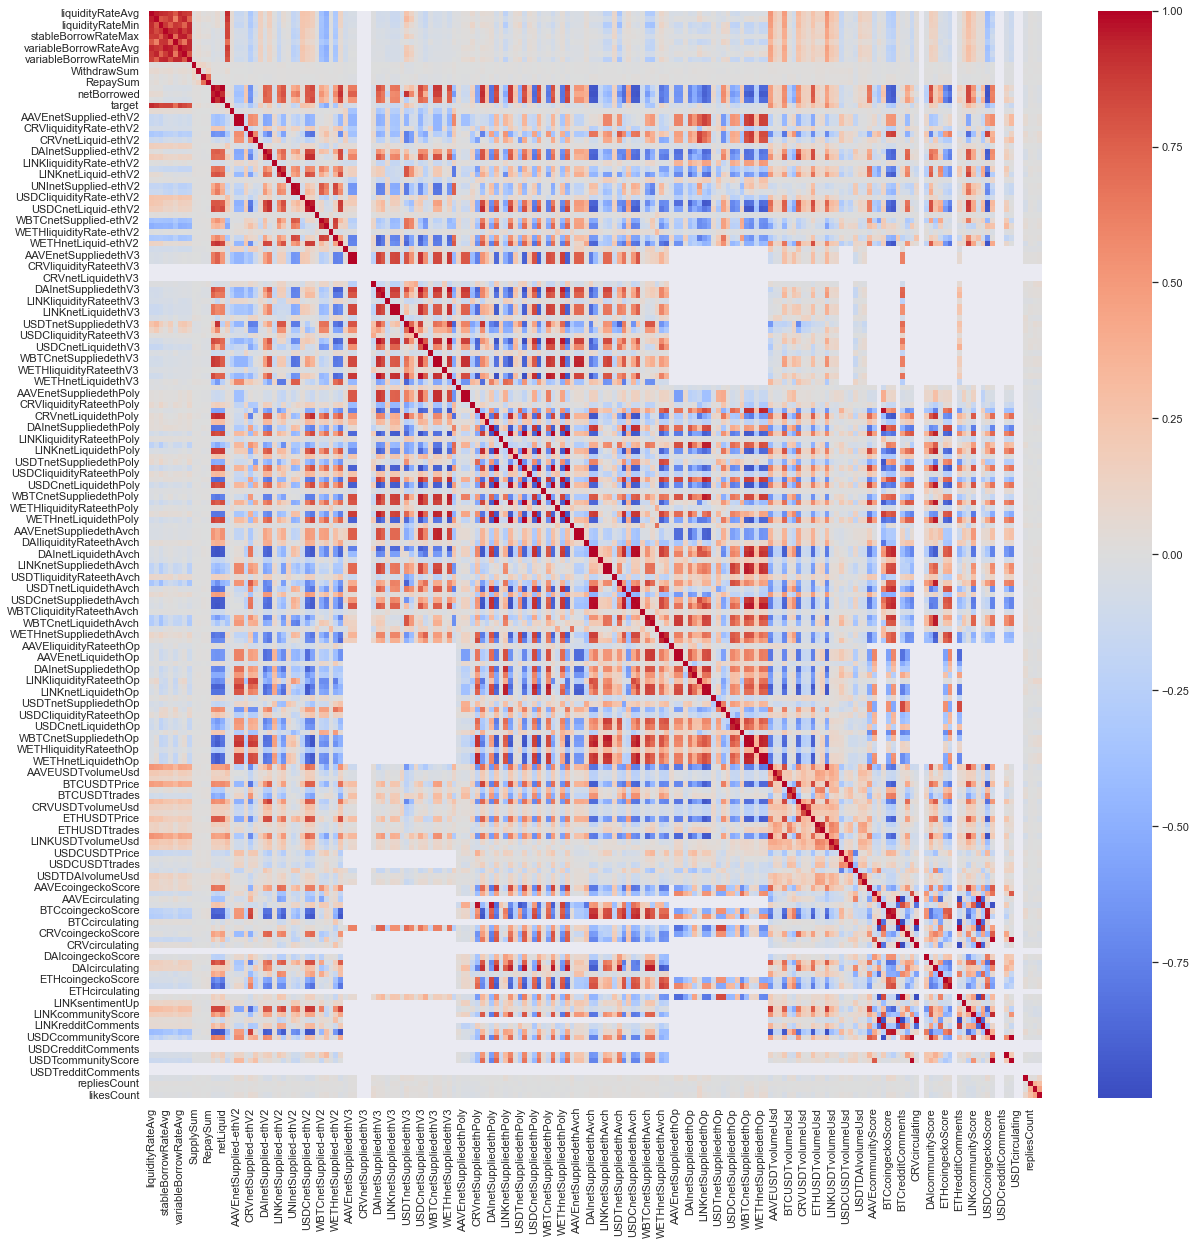

In [90]:
sns.set(rc={'figure.figsize':(20,20)})

corr_matrix = dataset.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

Many of the numerical variables are strongly correlated, so they probably explain something similar, but we're not going to rule any out for now.

Regarding the Target, it is seen that the strongest correlation is with the other variables of its own pool (which is logical), but there also seems to be some correlation with many of the other variables.

The fact that the "original" variables of the pool have a higher correlation than that of the target would seem to indicate that calculating the average of 12 rows running into the future complicates the prediction, but in principle it is something that we want to see how well the model behaves.

# Modeling

The objective of this task is to create a model to predict the Annual Percentage Rate (APR), therefore we must define the problem as one of **regression** (calculate the value of the ARP in a future moment of time).

Just as a comment, if this model is implemented in the future, my recommendation, given that what the Vault must decide "where to place the funds", would be to train a **multinomial classification** model with different pools of the same token as target (I can explain it in more detail in a call)

__________________

### Training

Training a LightGBM with 10 CV folds with all the variables since, in general, this model does not improve by the subtraction or modification of highly correlated variables, their transformation (logarithmic or similar) or the exclusion of extreme values:

In [109]:
# Split the data into training and testing sets
train_size = int(len(dataset) * 0.8)
train_data, test_data = dataset[:train_size], dataset[train_size:]

In [144]:
print(f"Train Data Min Date: {train_data.index.min()}")
print(f"Train Data Max Date: {train_data.index.max()}")
print(f"Test Data Min Date: {test_data.index.min()}")
print(f"Test Data Max Date: {test_data.index.max()}")

Train Data Min Date: 2021-03-01 00:55:00
Train Data Max Date: 2022-10-06 00:20:00
Test Data Min Date: 2022-10-06 00:25:00
Test Data Max Date: 2023-02-28 23:00:00


In [154]:
# Define the LightGBM model
model = lgb.LGBMRegressor(
    n_estimators=100,
    random_state=42,
    verbose=1
)

# Define the cross-validation strategy (takes into account the temporal order of the data)
cv = TimeSeriesSplit(n_splits=10)

# We use the root mean square error as the precision metric
mse_scores = []

# Train and evaluate the model for each fold of the cross-validation
for train_index, test_index in cv.split(train_data):
    X_train, y_train = train_data.iloc[train_index].loc[:, train_data.columns != 'target'], train_data.iloc[train_index].loc[:,'target']
    X_test, y_test = train_data.iloc[test_index].loc[:, train_data.columns != 'target'], train_data.iloc[test_index].loc[:,'target']

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_score = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse_score)
    
# Average the results to get the final performance estimate
mean_mse_score = np.mean(mse_scores)
print("Mean squared error: {:.6f}".format(mean_mse_score))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15207
[LightGBM] [Info] Number of data points in the train set: 15286, number of used features: 65
[LightGBM] [Info] Start training from score 0.090257
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15624
[LightGBM] [Info] Number of data points in the train set: 30570, number of used features: 101
[LightGBM] [Info] Start training from score 0.073457
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16112
[LightGBM] [Info] Number of data points in 

### Evaluation

Make predictions on the testing set and evaluate the model

In [155]:
X_test, y_test = test_data.loc[:, test_data.columns != 'target'], test_data.loc[:,'target']
y_pred = model.predict(X_test)
mse_score = mean_squared_error(y_test, y_pred)
print("Test mean squared error: {:.6f}".format(mse_score))

Test mean squared error: 0.001962


Plot the predicted values against the actual values only for the **Test Dataset**

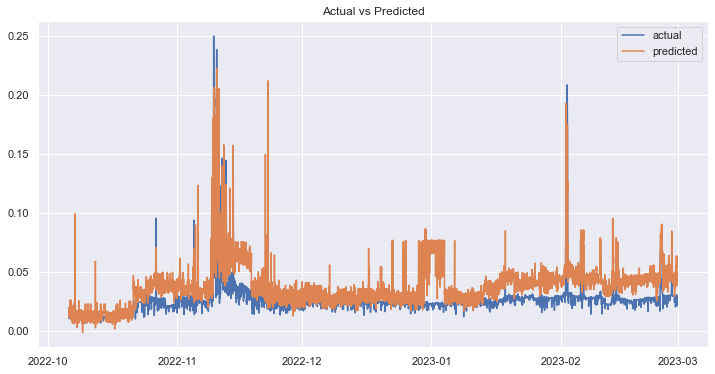

In [158]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_data.index, y_test, label='actual')
ax.plot(test_data.index, y_pred, label='predicted')
ax.legend()
ax.set_title('Actual vs Predicted')
plt.show()

Show Most relevant variables for the model 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

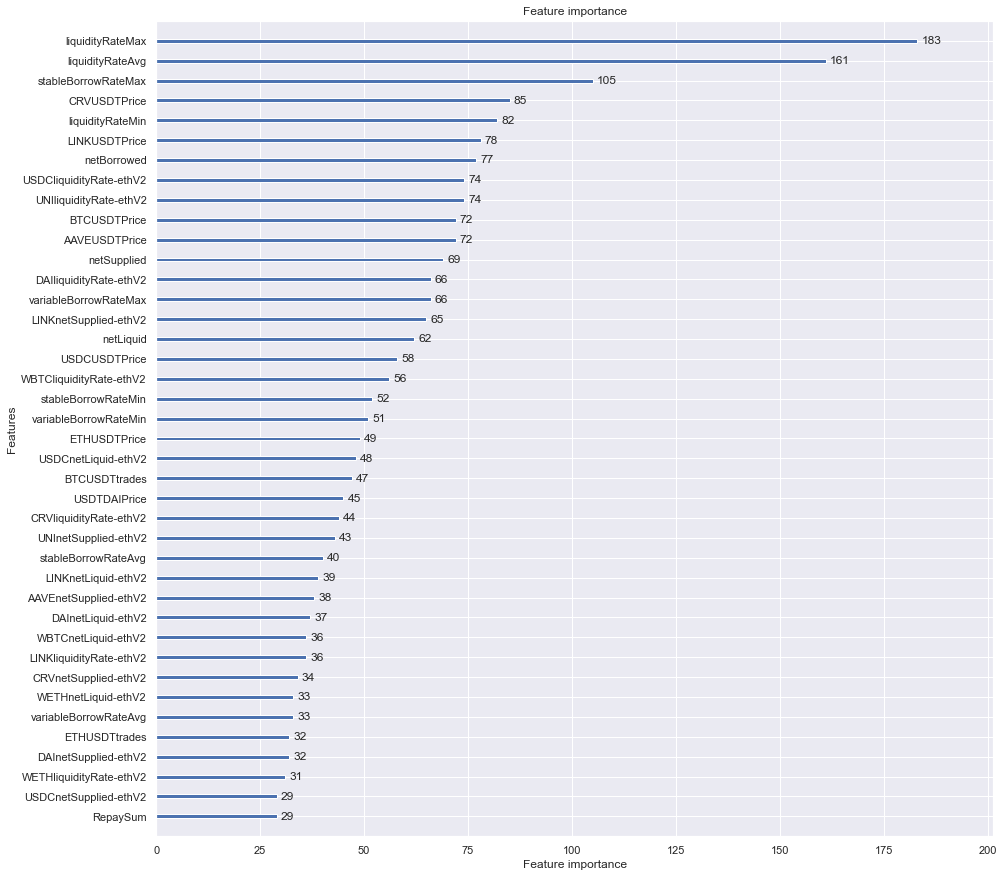

In [140]:
lgb.plot_importance(model, figsize = (15,15), max_num_features = 40)

## Hyperparameter Optimization

Bayesian optimization of model hyperparameters to improve accuracy

In [160]:
# Define the model again
estimator = lgb.LGBMRegressor(random_state=42)

# Define the search space for hyperparameters
search_space = {
    'learning_rate': Real(0.01, 0.5, prior='log-uniform'),
    'n_estimators': Integer(50, 2000),
    'max_depth': Integer(2, 20),
    'num_leaves': Integer(2, 1000),
    'min_child_samples': Integer(1, 50),
    'subsample': Real(0.1, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.1, 1.0, prior='uniform'),
    'reg_alpha': Real(1e-9, 100, prior='log-uniform'),
    'reg_lambda': Real(1e-9, 100, prior='log-uniform')
}

# Folds of CV
cv = TimeSeriesSplit(n_splits=10)

# Define the BayesSearchCV object with time restriction
search = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    n_iter=10,
    verbose=1,
)

# Fit the BayesSearchCV object to the training data
search.fit(train_data.loc[:, train_data.columns != 'target'], train_data.loc[:,'target'])


# Print the best hyperparameters and mean squared error
print("Best hyperparameters: ", search.best_params_)
print("Best negative mean squared error: {:.4f}".format(search.best_score_))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36025
[LightGBM] [Info] Number of data points in the train set: 168126, number of used features: 168
[LightGBM] [Info] Start trainin

Evaluate the model with the best hyperparameters on the test set

In [163]:
model = lgb.LGBMRegressor(**search.best_params_, random_state=42)
model.fit(train_data.loc[:, test_data.columns != 'target'], train_data.loc[:,'target'])
y_pred = model.predict(test_data.loc[:, test_data.columns != 'target'])
mse_score = mean_squared_error(test_data.loc[:,'target'], y_pred)
print("Test mean squared error: {:.4f}".format(mse_score))

Test mean squared error: 0.0001


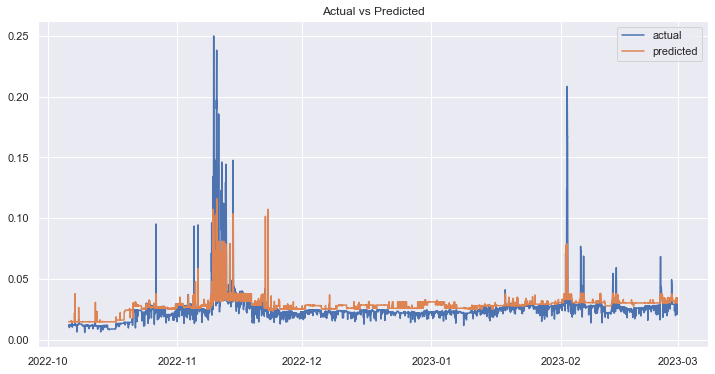

In [164]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_data.index, y_test, label='actual')
ax.plot(test_data.index, y_pred, label='predicted')
ax.legend()
ax.set_title('Actual vs Predicted')
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

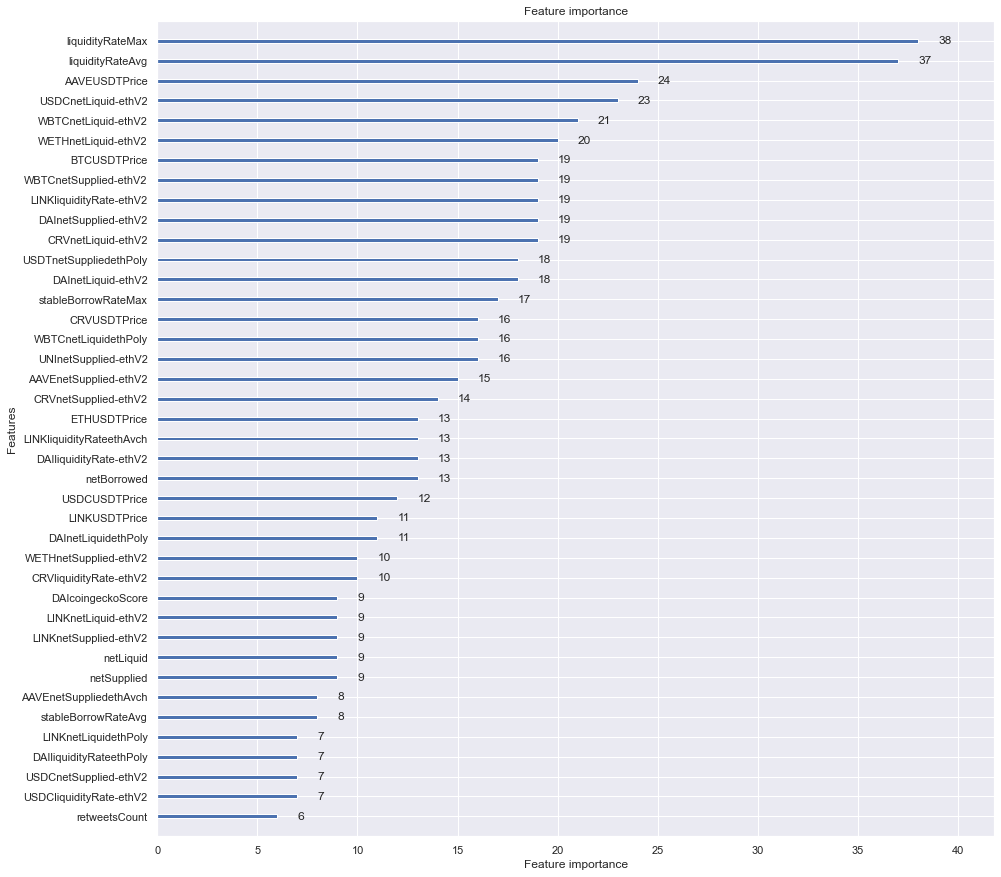

In [165]:
lgb.plot_importance(model, figsize = (15,15), max_num_features = 40)

With this we improve the model up to an MSE of **0.0001** using these parameters

I stop the exploration here, but you could continue with:

* The preprocessing and combination of relevant variables
* Transformation of highly volatile variables with rolling windows, row-to-row change or similar
* Try some kind of network based PCA style variable synthesizer
* A deep network model such as Transformers or simple LSTM that better interpret the temporality of the data

Outside of these points, it is worth rethinking, as discussed above, whether a regression model is really desired or whether it is better to go with a multinomial classification model to define capital allocations.